# ***Machine Learning model interpretation***

# üìö ***Import libraries***

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import load
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# üíæ ***Load model***

In [4]:
# Load the saved model (preprocessing + XGBoost)
covid_model = load("/workspaces/COVID_DAILY_COUNTS/models/covid_regression-xgboost-v1.joblib")

# ***Model Interpretation***

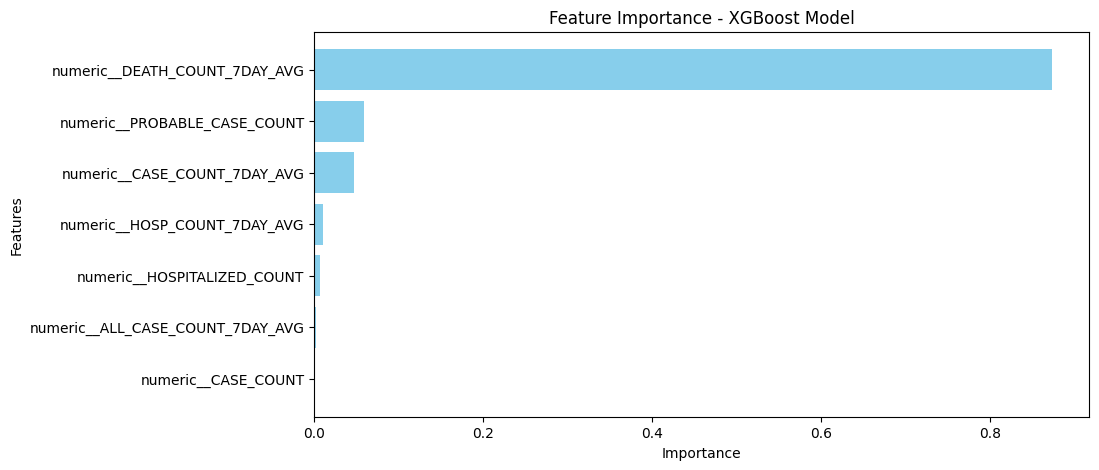

In [5]:
import pandas as pd

features = covid_model["preprocessor"].get_feature_names_out()

importances = covid_model["model"].feature_importances_

df_features = pd.DataFrame({"Features": features, "Importances": importances})
df_features = df_features.sort_values(by="Importances", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(df_features["Features"], df_features["Importances"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost Model")
plt.gca().invert_yaxis()
plt.show()

In [6]:
df_features

Features  Importances
6     numeric__DEATH_COUNT_7DAY_AVG     0.873947
1      numeric__PROBABLE_CASE_COUNT     0.059294
3      numeric__CASE_COUNT_7DAY_AVG     0.046675
5      numeric__HOSP_COUNT_7DAY_AVG     0.010063
2       numeric__HOSPITALIZED_COUNT     0.006500
4  numeric__ALL_CASE_COUNT_7DAY_AVG     0.002570
0               numeric__CASE_COUNT     0.000950

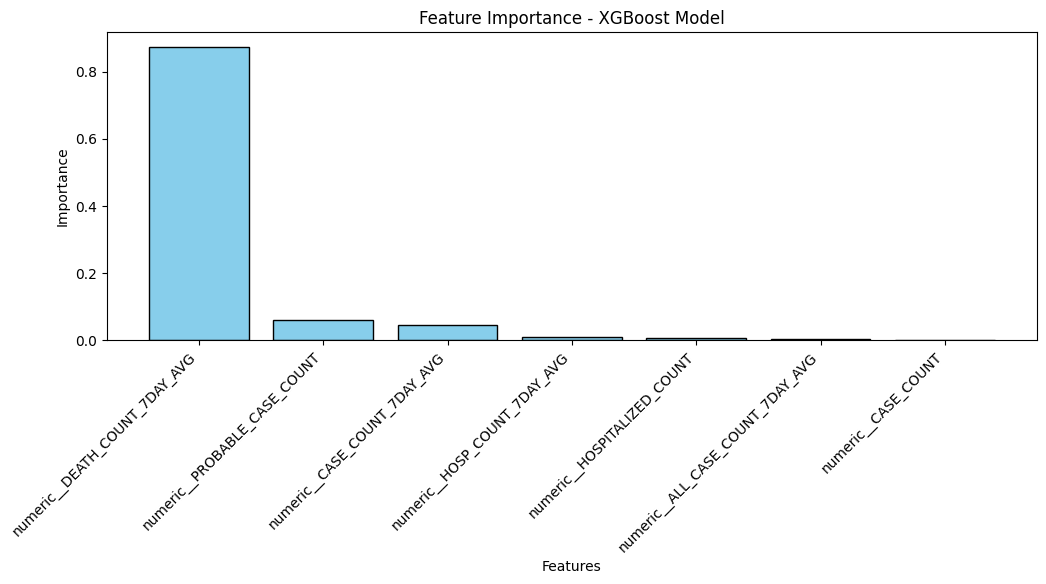

In [7]:
plt.figure(figsize=(12, 4))
plt.bar(
    df_features["Features"],
    df_features["Importances"],
    capsize=5,
    edgecolor="black",
    color="skyblue", 
)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance - XGBoost Model")
plt.xticks(rotation=45, ha="right")

plt.show()

## ***Feature permutation***
### üíæ ***Load data***

In [12]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"
covid_df = pd.read_parquet(DATA_DIR / "02_intermediate/covid_type_fixed.parquet", engine="pyarrow")

covid_df.loc[:, "DEATH_COUNT"] = covid_df["DEATH_COUNT"].astype(int)
covid_df = covid_df.drop_duplicates()

In [13]:
columnas_df = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "DEATH_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]
covid_df = covid_df[columnas_df].copy()

In [14]:
X_features = covid_df.drop(columns=["DEATH_COUNT"])
Y_target = covid_df["DEATH_COUNT"]

In [15]:
# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

/tmp/ipykernel_11093/2126605521.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


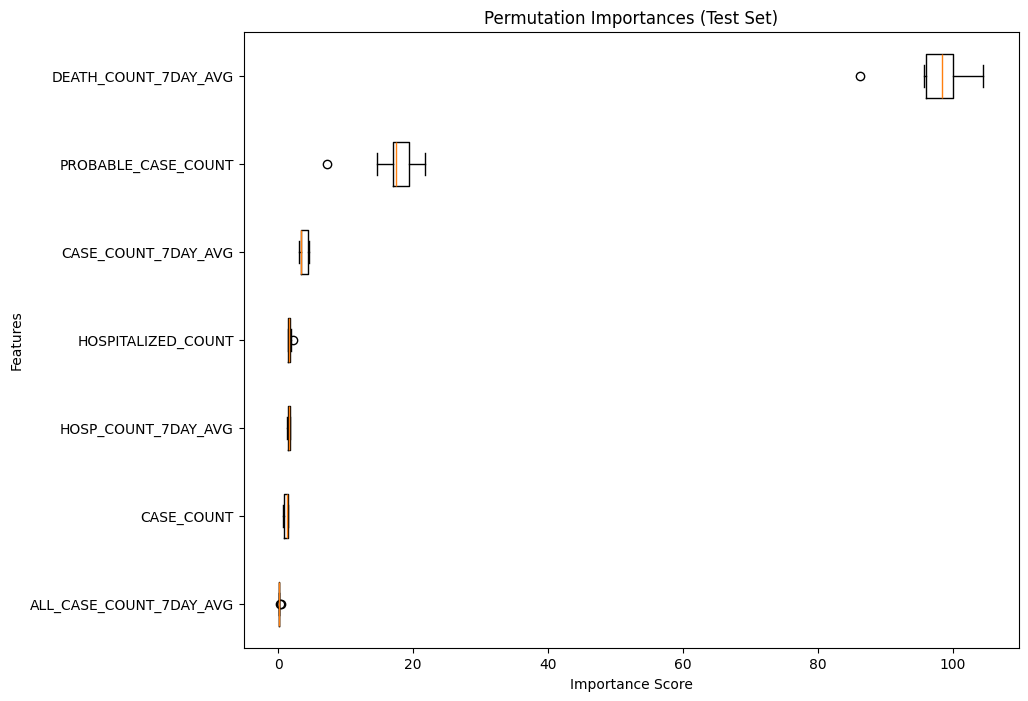

In [16]:
imps = permutation_importance(
    covid_model,
    x_test,
    y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    random_state=42,
    n_jobs=8,
)

# Ordenar las importancias de permutaci√≥n
perm_sorted_idx = imps.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(
    imps.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(x_test.columns)[perm_sorted_idx],
)
plt.title("Permutation Importances (Test Set)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

Las variables con mayor poder predictivo tendr√°n un mayor impacto en el rendimiento del modelo cuando se permuten. Bas√°ndose en los resultados, las caracter√≠sticas m√°s importantes es:
- DEATH_COUNT_7DAY_AVG

Con una importancia moderada:

- PROBABLE_CASE_COUNT
- CASE_COUNT_7DAY_AVG

# üìå ***Interpretaci√≥n del Modelo y An√°lisis de Errores***

## **1Ô∏è‚É£ Interpretaci√≥n del Modelo y Detecci√≥n de Errores**
El modelo seleccionado, **XGBoost**, mostr√≥ un excelente desempe√±o en la predicci√≥n del n√∫mero de muertes diarias por COVID-19 en la ciudad de Nueva York. Las m√©tricas evaluadas (MAE, MSE, R¬≤) indican que el modelo logra capturar adecuadamente la din√°mica de la pandemia en t√©rminos generales.

Sin embargo, el an√°lisis de errores revela dificultades para predecir valores extremos, especialmente durante picos pand√©micos. Esto sugiere que el modelo puede subestimar la mortalidad en contextos inusuales.

## **2Ô∏è‚É£ ¬øQu√© variables son m√°s importantes?**
Seg√∫n el an√°lisis de **importancia de caracter√≠sticas** (tanto por `feature_importance_` de XGBoost como por **importancia por permutaci√≥n**), las variables m√°s influyentes en la predicci√≥n son:

- `DEATH_COUNT_7DAY_AVG` ‚ö∞Ô∏è  
- `PROBABLE_CASE_COUNT` üß™  
- `CASE_COUNT_7DAY_AVG` üìà

La variable `DEATH_COUNT_7DAY_AVG` tiene una importancia **abrumadora** con m√°s del **87% de peso relativo**, lo que indica que el modelo conf√≠a casi exclusivamente en esta media m√≥vil para predecir las muertes.

## **3Ô∏è‚É£ ¬øCu√°nto aporta cada variable a la predicci√≥n?**
Con base en las gr√°ficas y tablas:

- **`DEATH_COUNT_7DAY_AVG`** representa aproximadamente el **87%** de la importancia total del modelo.  
- **`PROBABLE_CASE_COUNT`** contribuye con cerca de **6%**.  
- Otras variables (`CASE_COUNT_7DAY_AVG`, `HOSPITALIZED_COUNT`, etc.) tienen aportes menores a **5%**.

Este patr√≥n fue consistente tanto en la importancia directa del modelo como en el an√°lisis de permutaci√≥n sobre el set de prueba.

## **4Ô∏è‚É£ Consecuencias de Predicciones Incorrectas**
Errores en la predicci√≥n de muertes pueden tener implicaciones serias:

- **Subestimaci√≥n de muertes** üö®  
  - Puede generar respuestas insuficientes por parte del sistema de salud.  
  - Retrasos en la implementaci√≥n de medidas de emergencia.

- **Sobreestimaci√≥n de muertes** üò±  
  - Puede causar alarmismo innecesario.  
  - Afecta la percepci√≥n p√∫blica y puede tener impactos econ√≥micos o sociales.

Minimizar estos errores es clave para decisiones basadas en datos durante crisis sanitarias.

## **5Ô∏è‚É£ ¬øQu√© tipo de errores comete el modelo?**
El an√°lisis de residuos revela que los errores m√°s significativos ocurren en:

- **D√≠as con picos extremos de muertes.**  
- **Transiciones r√°pidas** entre per√≠odos de baja y alta mortalidad.  

Estos errores se concentran en los extremos del rango de valores, lo cual puede atribuirse a la escasa representaci√≥n de dichos eventos en el entrenamiento.

## **6Ô∏è‚É£ ¬øQu√© causa estos errores?**
Las posibles causas de los errores detectados incluyen:

‚úÖ **Dependencia excesiva de una sola variable:**  
   - La dominancia de `DEATH_COUNT_7DAY_AVG` podr√≠a estar ocultando el aporte de otras variables m√°s din√°micas.

‚úÖ **Falta de variables contextuales:**  
   - Factores como campa√±as de vacunaci√≥n, movilidad, o medidas de confinamiento no est√°n incorporadas, y podr√≠an mejorar la predicci√≥n en escenarios at√≠picos.

## üß™ ***Conclusi√≥n***
El modelo **XGBoost** es s√≥lido y preciso para la predicci√≥n de muertes por COVID-19, pero **su generalizaci√≥n ante valores extremos a√∫n puede mejorarse**.